In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #Esta hay que instalarla
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
base_path = os.getcwd()
players_file = os.path.join(base_path, "Datos", "players_22.csv")

players = pd.read_csv(players_file, encoding="utf-8")

features = ["overall", "potential", "wage_eur", "value_eur", "age"]
players = players.dropna(subset=features)

data = players[features].copy()

data.head()

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_3724\1192280948.py:4: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(players_file, encoding="utf-8")


,overall,potential,wage_eur,value_eur,age
0,93,93,320000.0,78000000.0,34
1,92,92,270000.0,119500000.0,32
2,91,91,270000.0,45000000.0,36
3,91,91,270000.0,129000000.0,29
4,91,91,350000.0,125500000.0,30


In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [4]:
n_clusters = 5
model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
players["cluster"] = model.fit_predict(scaled_data)

cluster_summary = (
    players.groupby("cluster")[features]
    .mean()
    .round(2)
    .assign(num_players=players["cluster"].value_counts().sort_index())
)

print("Resumen por clúster:")
print(cluster_summary)

Resumen por clúster:
         overall  potential   wage_eur    value_eur    age  num_players
cluster                                                                
0          67.25      67.75    5486.45   1049730.69  29.75         6836
1          66.38      75.40    5509.89   1966057.89  21.88         5407
2          76.74      79.24   36476.35  11898134.14  26.99         1983
3          84.56      86.96  139843.75  58841145.83  26.63          192
4          57.57      66.90    1352.73    406777.97  21.59         4747


In [8]:
# Puntaje: alta calidad y potencial, bajo costo
scaler = MinMaxScaler()

cluster_features = cluster_summary[["potential", "overall", "value_eur", "wage_eur"]].copy()
cluster_scaled = pd.DataFrame(scaler.fit_transform(cluster_features), columns=cluster_features.columns)

# Nuevo score: alto potential/overall, bajo value/wage
cluster_scaled["score"] = (
    cluster_scaled["potential"] * 0.4 +
    cluster_scaled["overall"] * 0.4 -
    cluster_scaled["value_eur"] * 0.1 -
    cluster_scaled["wage_eur"] * 0.1
)

best_cluster = cluster_scaled["score"].idxmax()
jugadores_objetivo = players.loc[players["cluster"] == best_cluster]

print(f"\nClúster objetivo (mejor relación calidad/precio): {best_cluster}")

print("\nJugadores del clúster objetivo:")
print(jugadores_objetivo[["short_name", "overall", "potential", "value_eur", "wage_eur", "age"]]
      .sort_values(by="potential", ascending=False)
      .head(50))


Clúster objetivo (mejor relación calidad/precio): 3

Jugadores del clúster objetivo:
              short_name  overall  potential    value_eur  wage_eur  age
6              K. Mbappé       91         95  194000000.0  230000.0   22
0               L. Messi       93         93   78000000.0  320000.0   34
5               J. Oblak       91         93  112000000.0  130000.0   28
21         G. Donnarumma       89         93  119500000.0  110000.0   22
29            E. Haaland       88         93  137500000.0  110000.0   20
1         R. Lewandowski       92         92  119500000.0  270000.0   32
8          M. ter Stegen       90         92   99000000.0  250000.0   29
44   T. Alexander-Arnold       87         92  114000000.0  150000.0   22
43            F. de Jong       87         92  119500000.0  210000.0   24
139             P. Foden       84         92   94500000.0  125000.0   21
138           K. Havertz       84         92   94500000.0  130000.0   22
18               Ederson       89     

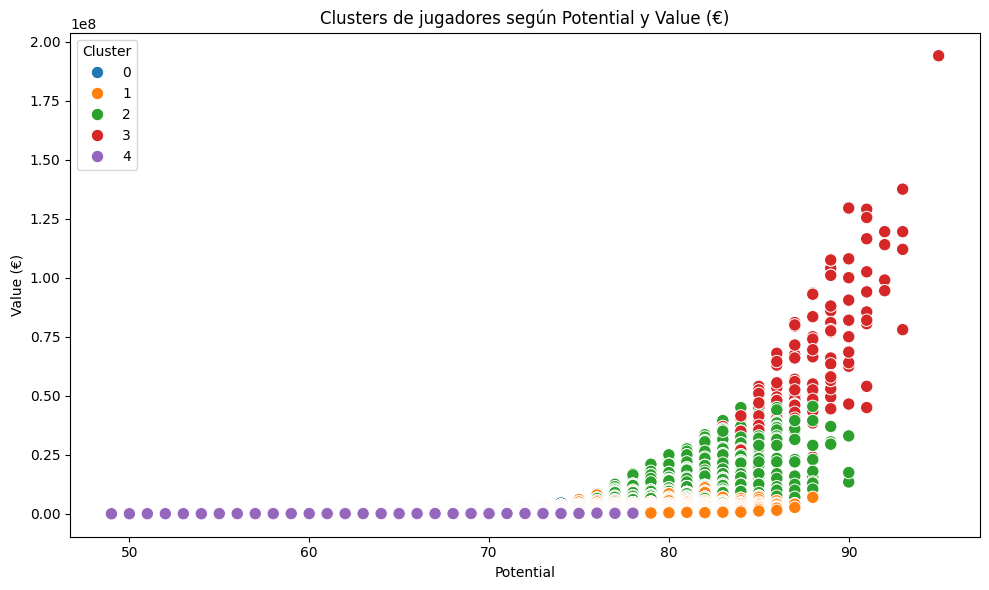

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="value_eur",
    hue="cluster", palette="tab10", alpha=1.0, s=80
)
plt.title("Clusters de jugadores según Potential y Value (€)")
plt.xlabel("Potential")
plt.ylabel("Value (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

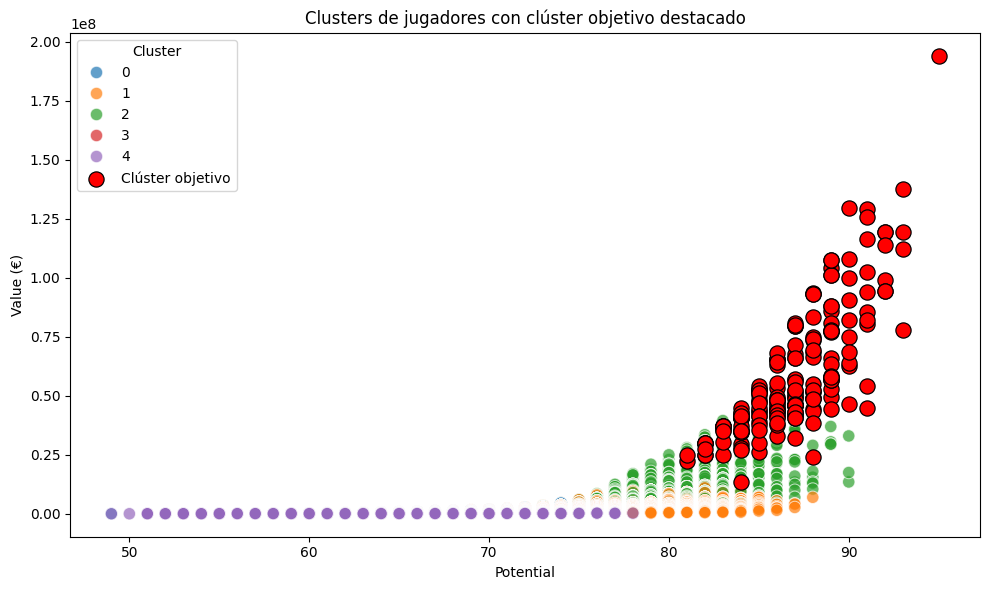

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="value_eur",
    hue="cluster", palette="tab10", alpha=0.7, s=80
)
sns.scatterplot(
    data=jugadores_objetivo, x="potential", y="value_eur",
    color="red", s=120, label="Clúster objetivo", edgecolor="k"
)
plt.title("Clusters de jugadores con clúster objetivo destacado")
plt.xlabel("Potential")
plt.ylabel("Value (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()